### E-08 : Ïù∏Î¨ºÏÇ¨ÏßÑ ÎßåÎì§Í∏∞ ÌîÑÎ°úÏ†ùÌä∏
1. Î≥∏Ïù∏ ÏÇ¨ÏßÑ, Í≥†ÏñëÏù¥ ÏÇ¨ÏßÑÏóê ÎåÄÌï¥ ÏÖ∏Î°úÏö∞ Ìè¨Ïª§Ïä§ Ìö®Í≥º Ï£ºÍ∏∞  
2. ÏúÑ Îëê ÏÇ¨ÏßÑÏúºÎ°ú ÌÅ¨Î°úÎßàÌÇ§  
3. Î¨∏Ï†úÏ†ê ÎèÑÏ∂ú
4. Î¨∏Ï†úÏ†ê Í∞úÏÑ†
5. ÌöåÍ≥†

### 1. Ìè¥Îçî ÏÉùÏÑ±

In [ ]:
$ mkdir -p ~/aiffel/human_segmentation/models
$ mkdir -p ~/aiffel/human_segmentation/images

### 2. ÌïÑÏöî Î™®Îìà import

In [1]:
import cv2
import numpy as np
import os
import tarfile
#urllib Ìå®ÌÇ§ÏßÄ :  ÏõπÏóêÏÑú Îç∞Ïù¥ÌÑ∞Î•º Îã§Ïö¥Î°úÎìúÌï† ÏÇ¨Ïö©
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

### 3. Ïù¥ÎØ∏ÏßÄ Î∂àÎü¨Ïò§Í∏∞

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Í∞ÄÏòÅ.jpg'  # Î≥∏Ïù∏Ïù¥ ÏÑ†ÌÉùÌïú Ïù¥ÎØ∏ÏßÄÏùò Í≤ΩÎ°úÏóê ÎßûÍ≤å Î∞îÍøî Ï£ºÏÑ∏Ïöî. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(2871, 2877, 3)


### 4. segmentation Ïù∏Î¨º Î∂ÑÎ¶¨ÌïòÍ∏∞

##### 1. DeepLabModel ÌÅ¥ÎûòÏä§ ÏÉùÏÑ±    
Íµ¨Í∏ÄÏóêÏÑú Tensorflow V1ÏúºÎ°ú ÏûëÏÑ±Ìïú DeepLab Î™®Îç∏ Íµ¨Ï°∞ ÌôúÏö© 

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()ÏóêÏÑú Î™®Îç∏ Íµ¨Ï°∞Î•º ÏßÅÏ†ë Íµ¨ÌòÑÌïòÎäî ÎåÄÏã†, tar fileÏóêÏÑú ÏùΩÏñ¥Îì§Ïù∏ Í∑∏ÎûòÌîÑÍµ¨Ï°∞ graph_defÎ•º 
    # tf.compat.v1.import_graph_defÎ•º ÌÜµÌï¥ Î∂àÎü¨Îì§Ïó¨ ÌôúÏö©ÌïòÍ≤å Îê©ÎãàÎã§. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)
    #preprocess() : Ï†ÑÏ≤òÎ¶¨
    # Ïù¥ÎØ∏ÏßÄÎ•º Ï†ÑÏ≤òÎ¶¨ÌïòÏó¨ Tensorflow ÏûÖÎ†•ÏúºÎ°ú  
    #ÏÇ¨Ïö© Í∞ÄÎä•Ìïú shapeÏùò Numpy ArrayÎ°ú Î≥ÄÌôòÌï©ÎãàÎã§.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        #resize : Î™®Îç∏Ïù¥ Î∞õÎäî ÏûÖÎ†• ÌÅ¨Í∏∞Í∞Ä Ï†ïÌï¥Ï†∏ ÏûàÏùå
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        #OpenCVÏùò ÎîîÌè¥Ìä∏ BGR Ï±ÑÎÑê ->ÌÖêÏÑúÌîåÎ°úÏö∞Ïóê ÎßûÎäî RGBÎ°ú ÏàòÏ†ï
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    # run() : Ïã§Ï†úÎ°ú ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖòÏùÑ ÌïòÎäî Ìï®Ïàò
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1ÏóêÏÑúÎäî model(input) Î∞©ÏãùÏù¥ ÏïÑÎãàÎùº sess.run(feed_dict={input...}) Î∞©ÏãùÏùÑ ÌôúÏö©Ìï©ÎãàÎã§.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

##### 2. ÏÇ¨Ï†ÑÏóê ÌïôÏäµÎêú Í∞ÄÏ§ëÏπò(pretrained weight) Î∂àÎü¨Ïò§Í∏∞  
Ïù¥Í≤ÉÎèÑ Íµ¨Í∏ÄÏóêÏÑú Ï†úÍ≥µ

In [4]:
#define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    #deeplabv3_mnv2_pascal_train_aug_2018_01_29 weight Îã§Ïö¥Î°úÎìú
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)
#DeepLabModel ÏùÑ Ï¥àÍ∏∞Ìôî
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


##### 3. Ïù¥ÎØ∏ÏßÄ ÎÑ§Ìä∏ÏõåÌÅ¨Ïóê ÏûÖÎ†•

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

#HWC(Height, Width, Channel) 
#img_orig Ïùò ÌÅ¨Í∏∞
#img_resized Ïùò ÌÅ¨Í∏∞
#ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖò ÎßµÏóêÏÑú Í∞ÄÏû• ÌÅ∞ Í∞í(Î¨ºÏ≤¥Î°ú Ïù∏ÏãùÎêú ÎùºÎ≤® Ï§ë Í∞ÄÏû• ÌÅ∞ Í∞í) =16

#1ÏóêÏÑú Ïù¥ÎØ∏ÏßÄ Î¶¨ÏÇ¨Ïù¥Ï¶àÎûë Î≠êÎûë Ìï† ÏàòÏûàÎäî DeepLab Î™®Îç∏ÏùÑ ÎßåÎì§ÏóàÏùå
#ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÎ•º Î™®Îç∏Ïóê ÎÑ£Ïñ¥ÏÑú Î¶¨ÏÇ¨Ïù¥Ï¶à + ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖò Îì±Îì±ÏùÑ Ìï®

(2871, 2877, 3) (511, 513, 3) 16


##### 4. DeepLabÏù¥ Ï†úÍ≥µÌïòÎäî PASCAL VOCÏùò ÎùºÎ≤®Î°ú ÌïôÏäµÎêú ÎùºÎ≤® Ï¢ÖÎ•ò ÌôïÏù∏Ìï¥Î≥¥Í∏∞

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

#backgroundÎ•º Ï†úÏô∏ÌïòÎ©¥ 20Í∞úÏùò ÌÅ¥ÎûòÏä§ 
#ÏÇ¨Îûå(person) ÎùºÎ≤®=15

21

##### 5. ÏÇ¨Îûå ÏòÅÏó≠ ÎßàÏä§ÌÇπ + ÏãúÍ∞ÅÌôîÌïòÍ∏∞

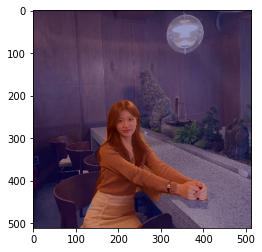

In [7]:
img_show = img_resized.copy()
#ÏÇ¨ÎûåÏùÑ ÎúªÌïòÎäî 15 Ïô∏ ÏòàÏ∏°ÏùÄ 0ÏúºÎ°ú = # ÏòàÏ∏° Ï§ë ÏÇ¨ÎûåÎßå Ï∂îÏ∂ú
#Í∑∏Îüº ÏòàÏ∏°Îêú ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖò Ïù¥ÎØ∏ÏßÄ(map)Îäî ÏµúÎåìÍ∞íÏù¥ 15
seg_map = np.where(seg_map == 15, 15, 0)

#ÏùºÎ∞ò Ïù¥ÎØ∏ÏßÄÎäî 0Î∂ÄÌÑ∞ 255 ÍπåÏßÄÏùò Í∞íÏùÑ ÏÇ¨Ïö©Ìï¥ ÌîΩÏÖÄÏùÑ ÌëúÌòÑ
#ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖò ÎßµÏóê ÌëúÌòÑÎêú Í∞íÏùÑ ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏóê Í∑∏Î¶º ÌòïÌÉúÎ°ú Ï∂úÎ†•ÌïòÍ∏∞ ÏúÑÌï¥ 
#255Î°ú Ï†ïÍ∑úÌôî
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
#applyColorMap(): ÏÉâ Ï†ÅÏö©
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 5. ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖò Í≤∞Í≥ºÎ•º ÏõêÎûò ÌÅ¨Í∏∞Î°ú Î≥µÏõêÌïòÍ∏∞  
DeepLab Î™®Îç∏ÏùÑ ÏÇ¨Ïö©ÌïòÍ∏∞ ÏúÑÌï¥ Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Î•º ÏûëÍ≤å resize Ìï¥ÏÑú ÏûÖÎ†•ÌñàÏùå  
(2871, 2877, 3)-> (511, 513, 3)  
ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖò Í≤∞Í≥º(mask)Î•º ÏõêÎûò ÌÅ¨Í∏∞Î°ú Î≥µÏõê

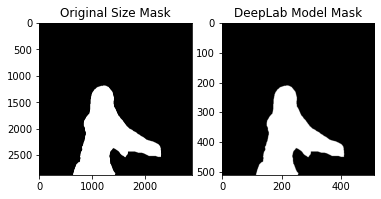

In [8]:
#cv2.resize() : 

#interpolation : Î≥¥Í∞Ñ (ÌôïÎåÄÏãúÌÇ¨Îïå Í≥†Î†§Ìï¥ÏïºÌï®)
#Ïù¥ÎØ∏ÏßÄÏùò ÌÅ¨Í∏∞Î•º Î≥ÄÍ≤Ω(scaling)ÌïòÎäî Í≥ºÏ†ïÏóêÏÑú Ïª¥Ìì®ÌÑ∞Í∞Ä ÏÇ¨Ïù¥ÏÇ¨Ïù¥ ÌîΩÏÖÄÍ∞íÏùÑ Ï±ÑÏö∞Îäî Î∞©Î≤ï
# ÌÜµÍ≥ÑÏ†Å ÌòπÏùÄ Ïã§ÌóòÏ†ÅÏúºÎ°ú Íµ¨Ìï¥ÏßÑ Îç∞Ïù¥ÌÑ∞Îì§(xi)Î°úÎ∂ÄÌÑ∞,
#Ï£ºÏñ¥ÏßÑ Îç∞Ïù¥ÌÑ∞Î•º ÎßåÏ°±ÌïòÎäî Í∑ºÏÇ¨ Ìï®Ïàò(f(x))Î•º Íµ¨ÌïòÍ≥†,
#Ïù¥ ÏãùÏùÑ Ïù¥Ïö©ÌïòÏó¨ Ï£ºÏñ¥ÏßÑ Î≥ÄÏàòÏóê ÎåÄÌïú Ìï®Ïàò Í∞íÏùÑ Íµ¨ÌïòÎäî ÏùºÎ†®Ïùò Í≥ºÏ†ï
#https://iskim3068.tistory.com/35
#https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html

# cv2.INTER_LINEAR : Ï†ïÌôïÌïòÍ≤å ÌôïÎåÄ (cv2.INTER_NEAREST : ÍπîÎÅîÌïòÍ≤å Ï≤òÎ¶¨)

#img_mask_up :  Í≤ΩÍ≥ÑÍ∞Ä Î∏îÎü¨Îêú ÌîΩÏÖÄÍ∞í 0~255Ïùò Ïù¥ÎØ∏ÏßÄÍ∞Ä Îê®
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
#ÌôïÏã§Ìïú Í≤ΩÍ≥ÑÎ•º Îã§Ïãú Ï†ïÌïòÍ∏∞ ÏúÑÌï¥ Ï§ëÍ∞ÑÍ∞íÏù∏ 128ÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÏûÑÍ≥ÑÍ∞í(threshold)ÏùÑ ÏÑ§Ï†ï
#= 128 Ïù¥ÌïòÎäî0, Ïù¥ÏÉÅÏùÄ 255 Í∞íÏùÑ ÎßåÎì¶
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 6. Î∞∞Í≤Ω ÌùêÎ¶¨Í≤å + Ï∂îÏ∂úÌïòÍ∏∞

##### 1. Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤¥ ÌùêÎ¶¨Í≤å

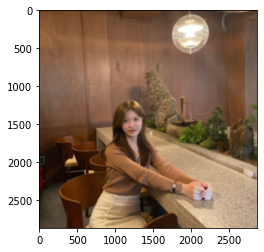

In [9]:
#blur(): ÌùêÎ¶¨Í≤å
img_orig_blur = cv2.blur(img_orig, (20,20)) #(13,13)ÏùÄ blurring  kernel sizeÎ•º ÎúªÌï©ÎãàÎã§. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

##### 2. ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖò  ÎßàÏä§ÌÅ¨ Ïù¥Ïö©Ìï¥ÏÑú Î∞∞Í≤ΩÎßå Ï∂îÏ∂ú

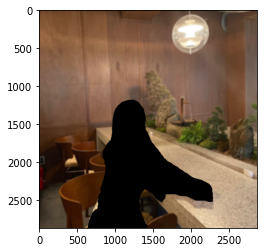

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
#bitwise_not : Ïù¥ÎØ∏ÏßÄÍ∞Ä Î∞òÏ†Ñ (ÏÇ¨ÎûåÏùÄ0, Î∞∞Í≤ΩÏùÄ 255)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 7.  ÌùêÎ¶∞ Î∞∞Í≤ΩÍ≥º ÏõêÎ≥∏ ÏòÅÏÉÅ Ìï©ÏÑ±

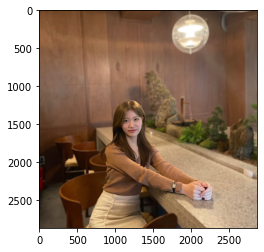

In [11]:
#ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖò ÎßàÏä§ÌÅ¨Í∞Ä 255Ïù∏ Î∂ÄÎ∂ÑÎßå ÏõêÎ≥∏ ÏòÅÏÉÅÏúºÎ°ú
#Î∞òÎåÄÏù∏ Í≤ΩÏö∞Ïóî Î∏îÎü¨Îêú ÎØ∏ÏßÄ Í∞í ÏÇ¨Ïö©
#np,where : https://numpy.org/doc/stable/reference/generated/numpy.where.html
img_concat_me = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat_me, cv2.COLOR_BGR2RGB))
plt.show()

img_show=()

### 8. ÏõêÎ≥∏, Shallow Focus ÎπÑÍµêÌï¥Î≥¥Í∏∞

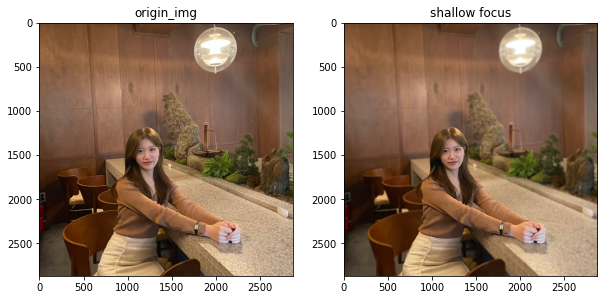

In [12]:
plt.figure(figsize=(10, 13))

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
ax.set_title('origin_img') 

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat_me, cv2.COLOR_BGR2RGB))
ax.set_title('shallow focus')

plt.show()

-----
## Í≥†ÏñëÏù¥ ÏÇ¨ÏßÑ ÏÖ∏Î°úÏö∞ Ìè¨Ïª§Ïä§ ÌïòÍ∏∞

### 1. Ïù¥ÎØ∏ÏßÄ Î∂àÎü¨Ïò§Í∏∞

In [13]:
img_path_cat = os.getenv('HOME')+'/aiffel/human_segmentation/images/Í≥†ÏñëÏù¥.jpg'  # Î≥∏Ïù∏Ïù¥ ÏÑ†ÌÉùÌïú Ïù¥ÎØ∏ÏßÄÏùò Í≤ΩÎ°úÏóê ÎßûÍ≤å Î∞îÍøî Ï£ºÏÑ∏Ïöî. 
img_orig_cat = cv2.imread(img_path_cat) 
print (img_orig_cat.shape)

(657, 620, 3)


### 2. Ïù¥ÎØ∏ÏßÄ ÎÑ§Ìä∏ÏõåÌÅ¨Ïóê ÏûÖÎ†•ÌïòÍ∏∞

In [14]:
img_resized_cat, seg_map_cat = MODEL.run(img_orig_cat)
print (img_orig_cat.shape, img_resized_cat.shape, seg_map_cat.max())

(657, 620, 3) (513, 484, 3) 8


### 3. ÌïôÏäµÎêú ÎùºÎ≤® Ï¢ÖÎ•ò ÌôïÏù∏

In [15]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### 4. Í≥†ÏñëÏù¥ ÏòÅÏó≠ ÎßàÏä§ÌÇπ + ÏãúÍ∞ÅÌôî

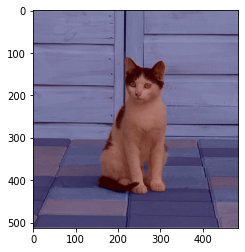

In [16]:
img_show_cat = img_resized_cat.copy()
#Í≥†ÏñëÏù¥Îäî ÎùºÎ≤® 8
seg_map_cat = np.where(seg_map_cat == 8, 8, 0)

#ÏùºÎ∞ò Ïù¥ÎØ∏ÏßÄÎäî 0Î∂ÄÌÑ∞ 255 ÍπåÏßÄÏùò Í∞íÏùÑ ÏÇ¨Ïö©Ìï¥ ÌîΩÏÖÄÏùÑ ÌëúÌòÑ
#ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖò ÎßµÏóê ÌëúÌòÑÎêú Í∞íÏùÑ ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄÏóê Í∑∏Î¶º ÌòïÌÉúÎ°ú Ï∂úÎ†•ÌïòÍ∏∞ ÏúÑÌï¥ 
#255Î°ú Ï†ïÍ∑úÌôî
img_mask_cat = seg_map_cat * (255/seg_map_cat.max())
img_mask_cat = img_mask_cat.astype(np.uint8)
#applyColorMap(): ÏÉâ Ï†ÅÏö©
color_mask = cv2.applyColorMap(img_mask_cat, cv2.COLORMAP_JET)
img_show_cat = cv2.addWeighted(img_show_cat, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show_cat, cv2.COLOR_BGR2RGB))
plt.show()

### 5. Ïù¥ÎØ∏ÏßÄ ÏÇ¨Ïù¥Ï¶à Î≥µÏõêÌïòÍ∏∞

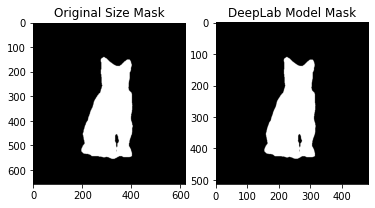

In [17]:
#img_mask_up :  Í≤ΩÍ≥ÑÍ∞Ä Î∏îÎü¨Îêú ÌîΩÏÖÄÍ∞í 0~255Ïùò Ïù¥ÎØ∏ÏßÄÍ∞Ä Îê®
img_mask_up_cat = cv2.resize(img_mask_cat, img_orig_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
#ÌôïÏã§Ìïú Í≤ΩÍ≥ÑÎ•º Îã§Ïãú Ï†ïÌïòÍ∏∞ ÏúÑÌï¥ Ï§ëÍ∞ÑÍ∞íÏù∏ 128ÏùÑ Í∏∞Ï§ÄÏúºÎ°ú ÏûÑÍ≥ÑÍ∞í(threshold)ÏùÑ ÏÑ§Ï†ï
#= 128 Ïù¥ÌïòÎäî0, Ïù¥ÏÉÅÏùÄ 255 Í∞íÏùÑ ÎßåÎì¶
_, img_mask_up_cat = cv2.threshold(img_mask_up_cat, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up_cat, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask_cat, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### 6. Î∞∞Í≤Ω ÌùêÎ¶¨Í≤å + Ï∂îÏ∂ú

##### 1. Ïù¥ÎØ∏ÏßÄ Ï†ÑÏ≤¥ ÌùêÎ¶¨Í≤å

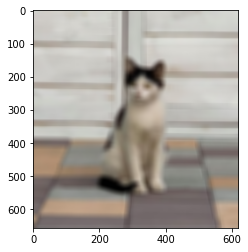

In [18]:
#blur(): ÌùêÎ¶¨Í≤å
img_orig_cat_blur = cv2.blur(img_orig_cat, (20,20)) #(13,13)ÏùÄ blurring  kernel sizeÎ•º ÎúªÌï©ÎãàÎã§. 
plt.imshow(cv2.cvtColor(img_orig_cat_blur, cv2.COLOR_BGR2RGB))
plt.show()

##### 2. ÌùêÎ¶¨Í≤åÌïú Î∞∞Í≤ΩÎßå segmentation maskÎ°ú Ï∂îÏ∂ú

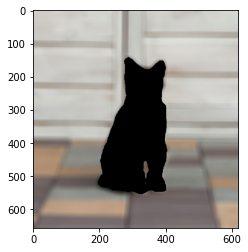

In [19]:
img_mask_color_cat = cv2.cvtColor(img_mask_up_cat, cv2.COLOR_GRAY2BGR)
#bitwise_not : Ïù¥ÎØ∏ÏßÄÍ∞Ä Î∞òÏ†Ñ (ÏÇ¨ÎûåÏùÄ0, Î∞∞Í≤ΩÏùÄ 255)
img_bg_mask_cat = cv2.bitwise_not(img_mask_color_cat)
img_bg_blur_cat = cv2.bitwise_and(img_orig_cat_blur, img_bg_mask_cat)
plt.imshow(cv2.cvtColor(img_bg_blur_cat, cv2.COLOR_BGR2RGB))
plt.show()

### 7. ÌùêÎ¶∞Î∞∞Í≤Ω Í≥†ÏñëÏù¥ Ïù¥ÎØ∏ÏßÄ Ìï©ÏπòÍ∏∞

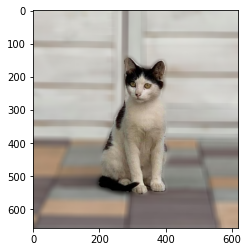

In [20]:
#ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖò ÎßàÏä§ÌÅ¨Í∞Ä 255Ïù∏ Î∂ÄÎ∂ÑÎßå ÏõêÎ≥∏ ÏòÅÏÉÅÏúºÎ°ú
#Î∞òÎåÄÏù∏ Í≤ΩÏö∞Ïóî Î∏îÎü¨Îêú ÎØ∏ÏßÄ Í∞í ÏÇ¨Ïö©
#np,where : https://numpy.org/doc/stable/reference/generated/numpy.where.html
img_concat_cat = np.where(img_mask_color_cat==255, img_orig_cat, img_bg_blur_cat)
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
plt.show()

img_show=()

### 8. ÏõêÎ≥∏, shallow focus Ïù¥ÎØ∏ÏßÄ ÎπÑÍµê

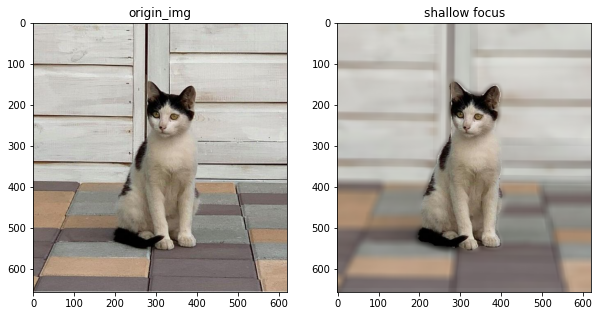

In [21]:
plt.figure(figsize=(10, 13))

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_orig_cat, cv2.COLOR_BGR2RGB))
ax.set_title('origin_img') 

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_concat_cat, cv2.COLOR_BGR2RGB))
ax.set_title('shallow focus')

plt.show()

-----
## ÏúÑ Îëê Ïù¥ÎØ∏ÏßÄÎ°ú ÌÅ¨Î°úÎßàÌÇ§ Ìï¥Î≥¥Í∏∞

### 1. Î∞∞Í≤Ω, Ïù¥ÎØ∏ÏßÄ, Ïù¥ÎØ∏ÏßÄ mask Î¶¨ÏÇ¨Ïù¥Ï¶à

In [22]:
# Ïù¥ÎØ∏ÏßÄ, Î∞∞Í≤ΩÏÇ¨ÏßÑ, Ïù¥ÎØ∏ÏßÄ mask Î¶¨ÏÇ¨Ïù¥Ï¶à
cat_resized = cv2.resize(img_orig_cat, (img_concat_me.shape[1], img_concat_me.shape[0]))
concat_me_resized = cv2.resize(img_concat_me, (img_concat_me.shape[1], img_concat_me.shape[0]))

cat_img_mask_resized = cv2.resize(img_mask_color_cat, (img_concat_me.shape[1], img_concat_me.shape[0]))

print(cat_resized.shape)
print(concat_me_resized.shape)
print(cat_img_mask_resized.shape)

(2871, 2877, 3)
(2871, 2877, 3)
(2871, 2877, 3)


### 2. Î∞∞Í≤Ω + Ïù¥ÎØ∏ÏßÄ Ìï©ÏπòÍ∏∞

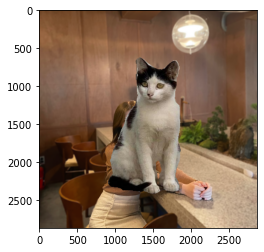

In [23]:
# Î∞∞Í≤Ω ÏòÅÏÉÅÍ≥º Í≥†ÏñëÏù¥ ÏòÅÏÉÅÏùÑ Ìï©ÏπòÍ∏∞
cat_me_concat = np.where(cat_img_mask_resized == 255, cat_resized, concat_me_resized)

plt.imshow(cv2.cvtColor(cat_me_concat, cv2.COLOR_BGR2RGB))
plt.show()

-----
## Î¨∏Ï†úÏ†ê

**1.Ïù∏Î¨ºÏùò Í≤ΩÍ≥ÑÏÑ† Ï≤òÎ¶¨**  
Í∑∏Î¶ºÏûê Î∂ÄÎ∂ÑÎèÑ Ïù∏Î¨ºÏù¥ÎùºÍ≥† Ïù∏ÏãùÌïòÍ≥†ÏûàÎã§.  
Í≤ΩÍ≥ÑÏÑ†Ïù¥ Î∂ÄÎìúÎüΩÍ≤å ÍπîÎÅîÌûà Ï≤òÎ¶¨Í∞Ä ÎêòÏßÄ ÏïäÍ≥† ÏûàÎã§  
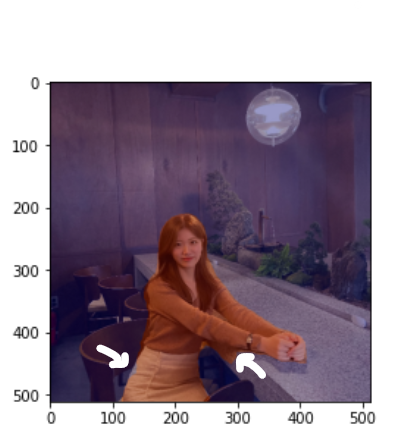

**2.Í≥†ÏñëÏù¥ Î¶¨ÏÇ¨Ïù¥Ï¶à, ÏúÑÏπò**  
Í≥†ÏñëÏù¥Ïùò ÏÇ¨Ïù¥Ï¶àÏôÄ ÏúÑÏπòÍ∞Ä Ïû¨Í≥†Î†§ ÎêòÏñ¥ÏïºÌïúÎã§  
ÎÇòÏùò ÏùòÎèÑÎäî ÎÇ¥ Ìåî ÏòÜÏóê Í≥†ÏñëÏù¥Í∞Ä Ïûò ÏïâÏïÑÏûàÎäî Í≤ÉÏù¥Îã§. 
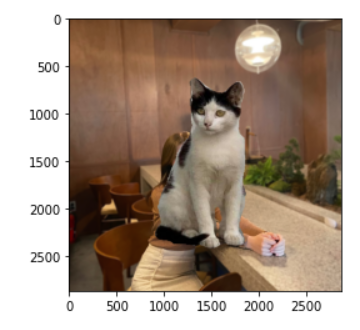

-----
## Î¨∏Ï†úÏ†ê Ìï¥Í≤∞

### 1. Ïù∏Î¨ºÏùò Í≤ΩÍ≥ÑÏÑ† Ïù∏Ïãù Í∞úÏÑ†_CRF
https://m.blog.naver.com/laonple/221017461464
http://swoh.web.engr.illinois.edu/courses/IE598/handout/fall2016_slide15.pdf

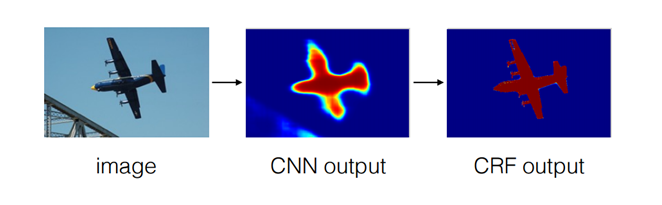
ÏãúÎ©òÌã± ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖòÏùÄ ÌîΩÏÖÄ Îã®ÏúÑ Ï°∞Î∞ÄÌïú ÏòàÏ∏° ÌïÑÏöî  
classfication ÎßùÏùÑ Í∏∞Î∞òÏúºÎ°ú -> segmentation Îßù Íµ¨ÏÑ±ÏãúÏóê feature map ÌÅ¨Í∏∞ Ï§ÑÏñ¥Îì¶  
ÎïåÎ¨∏Ïóê ÎîîÌÖåÏùºÌïú Ï†ïÎ≥¥ ÏñªÍ∏∞ ÌûòÎì¶  

##### ÎîîÌÖåÏùºÌïú Ï†ïÎ≥¥Î•º ÏúÑÌïú Ìï¥Í≤∞Ï±Ö
- **FCN** ÏóêÏÑú  
  **skip connection layer**ÏùÑ ÏÇ¨Ïö©  

- detailed convlution Ïù¥ÎÇò **DeepLab** ÏóêÏÑú  
  ÎßàÏßÄÎßâÏóê Ïò§Îäî pooling layer 2Í∞ú ÎåÄÏã† **dilated(atrous) convolution** ÏÇ¨Ïö©  

- Í∑∏ÎûòÎèÑ ÌïúÍ≥ÑÍ∞Ä Ï°¥Ïû¨ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê  
  **ÌõÑÏ≤òÎ¶¨** Í≥ºÏ†ïÏóê **CRF(conditional random field)** ÏÇ¨Ïö©  
  ÌîΩÏÖÄ Îã®ÏúÑ ÏòàÏ∏°Ïùò Ï†ïÌôïÎèÑ ÎÜíÏùº Ïàò ÏûàÏùå  

##### short-range CRF
ÏùºÎ∞òÏ†ÅÏúºÎ°ú Ï¢ÅÏùÄ Î≤îÏúÑ CRF = short-range CRF  
ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖò ÏàòÌñâ ÌõÑ ÏÉùÍ∏∞Îäî Ïû°Ïùå ÏóÜÏï†Îäî Ïö©ÎèÑÎ°ú ÏÇ¨Ïö©ÎêòÏóàÏùå  
ÌïòÏßÄÎßå DCNNÏóêÏÑúÎäî conv+pooling ÏúºÎ°ú ÌÅ¨Í∏∞ ÏûëÏïÑÏßÄÍ≥†  
Îã§Ïãú ÏõêÎûò ÏÇ¨Ïù¥Ï¶àÎ°ú upsampling ÌïòÍ∏∞ ÎïåÎ¨∏Ïóê Ï∂©Î∂ÑÌûà Î∂ÄÎìúÎü¨Ïö¥ ÏÉÅÌÉúÏûÑ  
Ïó¨Í∏∞Îã§Í∞Ä short-range CRFÎ•º ÌïòÎ©¥ Í≤∞Í≥ºÍ∞Ä Îçî ÎÇòÎπ†Ïßê  


##### Fully Connected CRF  
Ïù¥ÌõÑ Ïä§ÌÉ†Ìè¨ÎìúÎåÄÏóêÏÑú ÎÖºÎ¨∏ Î∞úÌëú  
Efficient Inference in Fully Connected CRFs with Gaussian Edge Potentials  
Ï†ÑÏ≤¥ ÌîΩÏÖÄÏùÑ Î™®Îëê Ïó∞Í≤∞Ìïú CRF Î∞©Î≤ï  

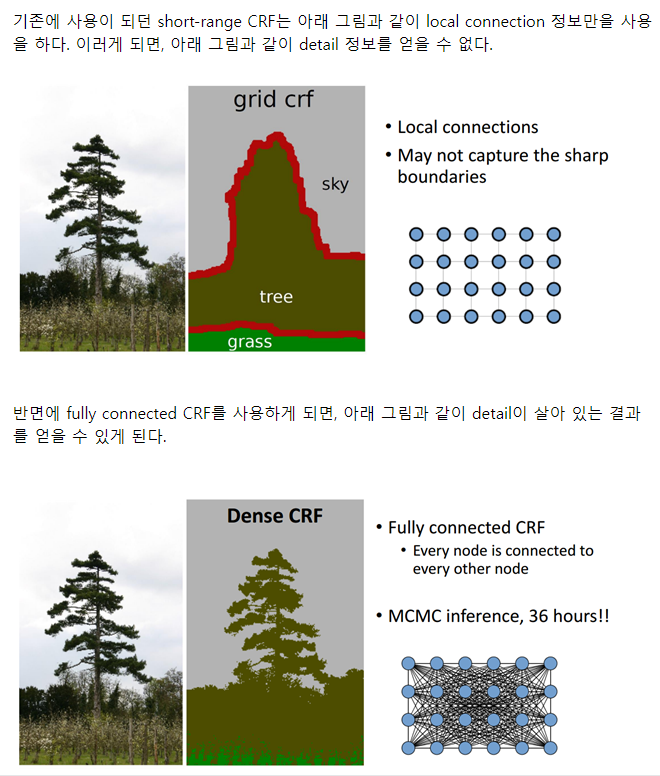

CRF ÏàòÏãù ÌôïÏù∏Ìï¥Î≥¥Î©¥, 2Í∞úÏùò Í∞ÄÏö∞ÏãúÏïà Ïª§ÎÑêÏù¥ Íµ¨ÏÑ±Îê®  
Ï≤´Î≤àÏß∏ Í∞ÄÏö∞ÏãúÏïà Ïª§ÎÑê : ÎπÑÏä∑Ìïú ÏúÑÏπò/Ïª¨Îü¨ Í∞ñÎäî ÌîΩÏÖÄÎì§Ïù¥ ÎπÑÏä∑Ìïú ÎùºÎ≤® Î∂ôÏùÑ Ïàò ÏûàÎèÑÎ°ù   
ÎëêÎ≤àÏß∏ Í∞ÄÏö∞ÏãúÏïà Ïª§ÎÑê : ÏõêÎûò ÌîΩÏÖÄ Ï†ëÍ∑ºÎèÑÏóê Îî∞Îùº smooth ÏàòÏ§ÄÏùÑ Í≤∞Ï†ïÌï®   
Ïù¥Í≤ÉÏùÑ Í≥†ÏÜç Ï≤òÎ¶¨ÌïòÍ∏∞ ÏúÑÌï¥ : ÏúÑ ÎÖºÎ¨∏Ïóê ÎÇòÏò® Î∞©Î≤ï ÏÇ¨Ïö©  

In [27]:
# Ïã§Ï†ú ÏΩîÎìú Íµ¨ÌòÑÏùÄ Î™ªÌï®

### 2. Í≥†ÏñëÏù¥ Î¶¨ÏÇ¨Ïù¥Ï¶à + ÏúÑÏπò ÏàòÏ†ï
EX_03 Í≥†ÏñëÏù¥ ÏàòÏóº ÎÖ∏Îìú Ï∞∏Í≥†

(1000, 850, 3)


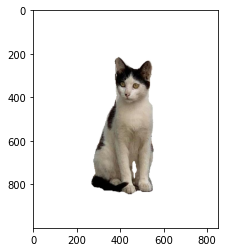

In [24]:
# Í≥†ÏñëÏù¥ ÏÇ¨ÏßÑ Ï∂îÏ∂ú Î∞è Î¶¨ÏÇ¨Ïù¥Ï¶à
cat = np.where(img_mask_color_cat==255, img_orig_cat, 255)
cat = cv2.resize(cat, dsize=(850, 1000), interpolation=cv2.INTER_CUBIC)

print(cat.shape)
plt.imshow(cv2.cvtColor(cat, cv2.COLOR_BGR2RGB))
plt.show()

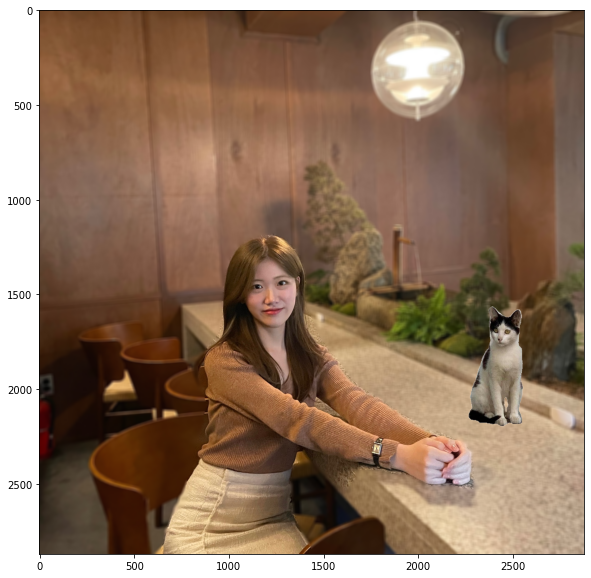

In [25]:
# Î¶¨ÏÇ¨Ïù¥Ï¶à ÏÇ¨ÏßÑ ÏúÑÏπòÏßÄÏ†ï + Î∞∞Í≤ΩÍ≥º Ìï©ÏÑ±ÌïòÍ∏∞
refined_y = 1350
refined_x = 2000

sticker_area = concat_me_resized[refined_y:refined_y+cat.shape[0], refined_x:refined_x+cat.shape[1]]
concat_me_resized[refined_y:refined_y+cat.shape[0], refined_x:refined_x+cat.shape[1]] = np.where(cat==255,sticker_area,cat).astype(np.uint8)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(concat_me_resized, cv2.COLOR_BGR2RGB))
#plt.axis('off')
plt.show()

-----
## Í∑∏ Ïô∏ ÎèÑÏ†Ñ_ Í∞ÄÏö∞ÏãúÏïà Î∏îÎü¨ÎßÅ
Í∞ÄÏö∞ÏãúÏïà Ïª§ÎÑê Í≤ΩÌóò ÏúÑÌï¥

Í∞ÄÏö∞ÏãúÏïà Î∏îÎü¨ÎßÅ  = Ï†ïÍ∑úÎ∂ÑÌè¨Ïóê Îî∞Î•∏ Î∏îÎü¨ÎßÅ  
https://hyongdoc.tistory.com/411

1. Í∞úÎÖê  
Í∞ÄÏö∞ÏãúÏïà Î∂ÑÌè¨Î•º Í∞ñÎäî Ïª§ÎÑêÎ°ú Î∏îÎü¨ÎßÅÏùÑ Ï†ÅÏö©Ìïú Í≤É  
Í∞ÄÏö∞ÏãúÏïà Î∂ÑÌè¨ Ìï®ÏàòÍ∞Ä Ï¢Ö ÌòïÌÉúÎ•º Ïù¥Î£®ÎìØ,  
Ïª§ÎÑê Í∞ÄÏö¥Îç∞ Í∞íÏù¥ Í∞ÄÏû• ÌÅ¨Í≥† + Ï§ëÏïôÏóêÏÑú Î©ÄÏàòÎ°ù Í∞íÏù¥ ÏûëÏùå  
<br>

2. Ï†ÅÏö© ÏΩîÎìú (2Í∞ÄÏßÄ Î∞©Î≤ï Ï°¥Ïû¨)  
1) Í∞ÄÏö∞ÏãúÏïà Ïª§ÎÑê ÏÉùÏÑ± ÏΩîÎìú  
cv2.getGaussianKernel(Ïª§ÎÑê ÌÅ¨Í∏∞,ÌëúÏ§ÄÌé∏Ï∞®) 

  - Ïª§ÎÑêÎßå ÏÉùÏÑ±ÌïòÎäî Ìï®Ïàò
  - Í∞ÄÏö∞ÏãúÏïà Ïª§ÎÑêÏùò return Í∞í = 1Ï∞®Ïõê Î∞∞Ïó¥  
    cv2.filter2D() Ìï®Ïàò Ï†ÅÏö© ÏúÑÌï¥ÏÑúÎäî  
    Ïª§ÎÑêÍ≥º Ïª§ÎÑêÏùò Ï†ÑÏπòÌñâÎ†¨ Í≥±Ìïú Í∞í Ïù∏ÏûêÎ°ú ÏÇ¨Ïö©Ìï¥ÏïºÌï®  
  - 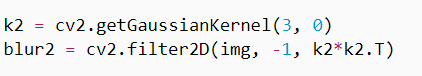
2) Í∞ÄÏö∞ÏãúÏïà Î∏îÎü¨ÎßÅ Ï†ÅÏö© ÏΩîÎìú  
cv2.GaussianBlur(ÏûÖÎ†• ÏòÅÏÉÅ, Ïª§ÎÑê ÌÅ¨Í∏∞, x Î∞©Ìñ• ÌëúÏ§ÄÌé∏Ï∞®, [yÎ∞©Ìñ• ÌëúÏ§ÄÌé∏Ï∞®,Í≤ΩÍ≥Ñ Î≥¥Ï†ï Î∞©Î≤ï])  
  - GaussianBlur(src, ksize, sigmaX)
  - Ïù¥ÎØ∏ÏßÄÏóê Í∞ÄÏö∞ÏãúÏïà Ï≤òÎ¶¨ÍπåÏßÄ ÌïúÎ∞©Ïóê Ìï¥Í≤∞ÌïòÎäî ÏΩîÎìú  
  - 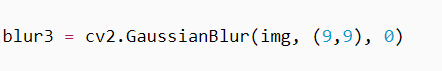

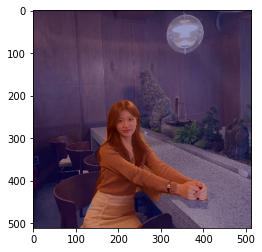

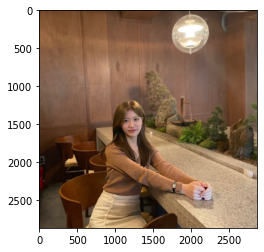

In [26]:
#1. Ïù∏Î¨º ÏõêÎ≥∏ Ïù¥ÎØ∏ÏßÄ Í∞ÄÏ†∏Ïò§Í∏∞
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/Í∞ÄÏòÅ.jpg'  # Î≥∏Ïù∏Ïù¥ ÏÑ†ÌÉùÌïú Ïù¥ÎØ∏ÏßÄÏùò Í≤ΩÎ°úÏóê ÎßûÍ≤å Î∞îÍøî Ï£ºÏÑ∏Ïöî. 
img_orig = cv2.imread(img_path) 

#2. Ï§ÄÎπÑÌïú Ïù¥ÎØ∏ÏßÄ ÎÑ§Ìä∏ÏõåÌÅ¨Ïóê ÏûÖÎ†•
img_resized, seg_map = MODEL.run(img_orig)

#3. Ïù∏Î¨º ÏòÅÏó≠ ÎßàÏä§ÌÇπ
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0)
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

#4. Î™®Îç∏ÏóêÏÑú resize ÌñàÎçòÍ≤É ÏõêÎûò ÌÅ¨Í∏∞Î°ú Î≥µÏõê
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#Ïù¥ ÏïÑÎûòÎ∂ÄÌÑ∞ Î∂ÄÎ∂Ñ Ïö∞ÏàòÎÖ∏Îìú Ï∞∏Í≥† (Í≥ÑÏÜç Ïò§Î•òÎÇ® „Ö†„Ö†„Ö†)

#5. img_mask_upÏùò Ï±ÑÎÑêÏùÑ ÏõêÎ≥∏ ÏÇ¨ÏßÑÍ≥º ÎßûÍ≤å 3 channelÎ°ú Î∞îÍøà
img_mask_3C = np.repeat(np.expand_dims(img_mask_up, axis=2), 3, axis=2).astype(np.uint8)

#6. Ïù∏Î¨ºÏù¥ÎØ∏ÏßÄ Í∞ÄÏö∞ÏãúÏïà Î∏îÎü¨ÎßÅ
img_orig_Gb = cv2.GaussianBlur(img_orig, (25,25), 0)

#7. ÎßàÏä§ÌÇπ Ïù¥ÎØ∏ÏßÄ Í∞ÄÏö∞ÏãúÏïà Î∏îÎü¨ÎßÅ
img_Gmask = (cv2.GaussianBlur(img_mask_3C, (101, 101), 25, 25)/255).astype(np.float32)

#8. ÎßàÏä§ÌÅ¨ÏôÄ Ïù¥ÎØ∏ÏßÄ ÎçîÌï¥Ï§å
image_blur = img_Gmask*img_orig.astype(np.float32)

#9. ÎßàÏä§ÌÅ¨Î•º Ìï¥Ï§òÏÑú Blur Ï≤òÎ¶¨Ìïú ÏõêÎ≥∏ÏóêÏÑú Î∞∞Í≤ΩÎßå ÎΩëÏïÑÎÉÑ
img_bg_mask = (1-img_Gmask)*img_orig_Gb.astype(np.float32)
img_output2 = (image_blur+img_bg_mask).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_output2, cv2.COLOR_BGR2RGB))
plt.show()

## ÌöåÍ≥†

üíö**Î£®Î∏åÎ¶≠**
1. Ïù∏Î¨ºÎ™®Îìú ÏÇ¨ÏßÑÏùÑ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Ï†úÏûëÌïòÏòÄÎã§.  
ÏïÑÏõÉÌè¨Ïª§Ïã± Ìö®Í≥ºÍ∞Ä Ï†ÅÏö©Îêú Î≥∏Ïù∏Ïùò Ïù∏Î¨ºÎ™®Îìú ÏÇ¨ÏßÑÍ≥º Í≥†ÏñëÏù¥ ÏÇ¨ÏßÑ,  
Î∞∞Í≤ΩÏ†ÑÌôò ÌÅ¨Î°úÎßàÌÇ§ÏÇ¨ÏßÑÏùÑ Í∞ÅÍ∞Å 1Ïû• Ïù¥ÏÉÅ ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Ï†úÏûëÌï®
<br>

2. Ï†úÏûëÌïú Ïù∏Î¨ºÎ™®Îìú ÏÇ¨ÏßÑÎì§ÏóêÏÑú ÎÇòÌÉÄÎÇòÎäî Î¨∏Ï†úÏ†êÏùÑ Ï†ïÌôïÌûà ÏßÄÏ†ÅÌïòÏòÄÎã§.  
Ïù∏Î¨ºÏÇ¨ÏßÑÏóêÏÑú Î∞úÏÉùÌïú Î¨∏Ï†úÏ†êÏùÑ Ï†ïÌôïÌûà ÏßÄÏ†ÅÌïú ÏÇ¨ÏßÑÏùÑ Ï†úÏ∂úÌï®  
<br>

3. Ïù∏Î¨ºÎ™®Îìú ÏÇ¨ÏßÑÏùò Î¨∏Ï†úÏ†êÏùÑ Í∞úÏÑ†Ìï† Ïàò ÏûàÎäî ÏÜîÎ£®ÏÖòÏùÑ Ï†ÅÏ†àÌûà Ï†úÏãúÌïòÏòÄÎã§.  
1) fully connected CRFÎ•º Ï†úÏãú  
2) Í≥†ÏñëÏù¥ ÎßàÏä§ÌÇπ Ïù¥ÎØ∏ÏßÄ Î¶¨ÏÇ¨Ïù¥Ï¶à + ÏÇ¨ÏßÑ ÏúÑÏπò ÏßÄÏ†ïÌï®  

üíö**Ïñ¥Î†§Ïõ†ÎçòÏ†ê**  
ÏãúÎ©òÌã± ÏÑ∏Í∑∏Î©òÌÖåÏù¥ÏÖòÏóê ÎåÄÌïú Í∞úÎÖêÏùÑ Í≥µÎ∂ÄÌïòÎ©¥ÏÑú  
ÌùêÎ¶ÑÏùÑ Îî∞Îùº Íµ¨ÌòÑÌï¥ÎÇ¥Î≥¥Í≥†, Î∞òÎ≥µ Íµ¨ÌòÑ ÌïòÎ©¥ÏÑú  
Ïñ¥ÎäêÏ†ïÎèÑ ÏùµÏàôÌï¥Ïßê  
ÌïòÏßÄÎßå ÏïÑÏßÅ ÏΩîÎìú by ÏΩîÎìúÎ°ú Î™®Îëê Ïù¥Ìï¥ÌïòÏßÄÎäî Î™ªÌñàÏùå  

üíö**Ïù¥ÌõÑ Í∞úÏÑ†ÌïòÍ≥† Ïã∂ÏùÄ Ï†ê**  
fully connected CRFÏóê ÎåÄÌïú ÎÖºÎ¨∏ÏùÑ ÍπäÍ≤å Ïù¥Ìï¥ÌïòÍ≥†,  
Ìï¥Îãπ Í∏∞Ïà†ÏùÑ ÏßÅÏ†ë Íµ¨ÌòÑÌï¥Î≥¥Í≥† Ïã∂Ïùå   